# Basic tutorial on how to use the quantum simulators

### This tutorial shows the basic idea of how to use the quantum assisted package to carry out Quantum Assisted Simulator (QAS), Truncated Taylor Quantum Simulator (TTQS) and the Classical Quantum Fast-Forwarding

Quantum Assisted Simulator: https://arxiv.org/abs/2011.06911, https://arxiv.org/abs/2011.14737, https://arxiv.org/abs/2101.07677

Truncated Taylor Quantum Simulator: https://arxiv.org/abs/2103.05500

Classical Quantum Fast-Forwarding: https://arxiv.org/abs/2104.01931

First, we describe how to use the quantum simulators without Qiskit, then we describe how we can use Qiskit to do the quantum simulation directly on the IBMQ computer.

# Using the quantum simulators without Qiskit

### Import Packages

In [1]:
import numpy as np 
import ansatz_class_package as acp 
import pauli_class_package as pcp 
import hamiltonian_class_package as hcp 
import matrix_class_package as mcp 
import post_processing as pp
import plotting_package as plotp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Set parameters for the evaluation

In [2]:
uptowhatK = 5
num_qubits = 3
endtime = 8
num_steps = 1001

### Create the initial state (starting quantum state that will be used in QAS, TTQS and CQFF). Also define Hamiltonian here.

This initial state is basically $|\psi>$ in Definition 1 in https://arxiv.org/abs/2011.06911

In [3]:
#create initial state
initial_state = acp.Initialstate(num_qubits, "efficient_SU2", 123, 5)
#define Hamiltonian
hamiltonian = hcp.transverse_ising_model_1d(num_qubits)

#We can define arbitrary Hamiltonians
#EXAMPLE: If we have a 4 qubit system and I want to implement the hamiltonian H = 0.6*(XXII) + 0.4*(XZIY), the hamiltonian will be generated with this:   
#hcp.generate_arbitrary_hamiltonian(4,[0.6,0.4],["1100","1302"])

### How to run TTQS

This following segment shows how the code is meant to work.

1. Create initial Ansatz for K = 0
2. We need to iterate up to whatever K we want to go up to
3. At the start of each iteration, we use the Ansatz for the previous round to generate the new Ansatz. Typically done by the method described in QAS, by generating the new moments and adding them to the existing Ansatz (cumulative K-moment states)
4. Use the Ansatz to generate the E and D matrices, and set the initial alphas (the actual starting state we wish to perform time evolution on)
5. Specify parameters for the TTQS instance and evaluate
6. Update the Ansatz with the new alphas (basically the results of the evaluation)

In [4]:
#Run TTQS

#Some extra parameters for TTQS
optimizer = 'eigh'
inv_cond = 10**(-6)

#create Initial Ansatz for K = 0
ansatz = acp.initial_ansatz(num_qubits)
#finalresults
finalresults = []
finalresults.append(ansatz)

for k in range(1,uptowhatK+1):
    print('Currently at K = ' + str(k))
    #Generate Ansatz for this round
    ansatz = acp.gen_next_ansatz(ansatz, hamiltonian, num_qubits) #By default, there is no processing when generating next Ansatz
    
    #Set initial alphas for Ansatz
    #Only 'start_with_initial_state' has been implemented thus far. 
    #This basically sets the state we want to evolve as the random, initial state we are using to generate the E and D matrices, for convenience
    acp.set_initial_alphas(num_qubits,ansatz,'start_with_initial_state')
    E_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "E")
    D_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "D")
    
    #Here is where we should be able to specify how to evaluate the matrices. However only the exact method (classical matrix multiplication) has been implemented so far
    E_mat_evaluated =  E_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)
    D_mat_evaluated = D_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)
    
    #Get starting alphas
    startingstrings,startingalphas = ansatz.get_alphas()
    
    #Initialize TTQS instance and specify parameters
    TTQS_instance = pp.TTQS(num_qubits,D_mat_evaluated,E_mat_evaluated,startingalphas)
    TTQS_instance.numberstep(num_steps)
    TTQS_instance.define_endtime(endtime)
    TTQS_instance.define_optimizer(optimizer)
    TTQS_instance.define_invcond(inv_cond)
    
    #Run TTQS instance
    TTQS_instance.evaluate()

    #Get results
    result = TTQS_instance.get_results()

    #Update ansatz with the new alphas
    ansatz.update_alphas(result)

    #Update final results with this
    finalresults.append(ansatz)
finalresultsTTQS = finalresults

Currently at K = 1
there are 6 states in CSk
Setting initial alphas
Currently at K = 2
there are 16 states in CSk
Setting initial alphas
Currently at K = 3
there are 26 states in CSk
Setting initial alphas
Currently at K = 4
there are 31 states in CSk
Setting initial alphas
Currently at K = 5
there are 32 states in CSk
Setting initial alphas


Now, finalresultsTTQS is a list of Ansatzes, each Ansatz basically stores the results for that run.

Example, Final results might look like this [Ansatz_0,Ansatz_1,Ansatz_2,Ansatz_3].

Where Ansatz_1 is an Ansatz class, which was used for the K=1 run, and contains the final results for that run

### How to run QAS

This following segment shows how the code is meant to work. Very similar to TTQS

1. Create initial Ansatz for K = 0
2. We need to iterate up to whatever K we want to go up to
3. At the start of each iteration, we use the Ansatz for the previous round to generate the new Ansatz. Typically done by the method described in QAS, by generating the new moments and adding them to the existing Ansatz (cumulative K-moment states)
4. Use the Ansatz to generate the E and D matrices, and set the initial alphas (the actual starting state we wish to perform time evolution on)
5. Specify parameters for the QAS instance and evaluate
6. Update the Ansatz with the new alphas (basically the results of the evaluation)

In [5]:
#Run QAS

#Some extra parameters for QAS
p_invcond = 10**(-6)
optimizer = 'zvode'

#create Initial Ansatz for K = 0
ansatz = acp.initial_ansatz(num_qubits)
#finalresults
finalresults = []
finalresults.append(ansatz)

for k in range(1,uptowhatK+1):
    print(k)

    #Generate Ansatz for this round
    ansatz = acp.gen_next_ansatz(ansatz, hamiltonian, num_qubits)

    #Set initial alphas for Ansatz
    acp.set_initial_alphas(num_qubits,ansatz,'start_with_initial_state')

    E_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "E")
    D_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "D")

    #Here is where we should be able to specify how to evaluate the matrices. However only the exact method (classical matrix multiplication) has been implemented so far
    E_mat_evaluated =  E_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)
    D_mat_evaluated = D_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)

    #Get starting alphas
    startingstrings,startingalphas = ansatz.get_alphas()

    #initialize QAS instance
    QAS_instance = pp.QAS(num_qubits, D_mat_evaluated, E_mat_evaluated, startingalphas)
    QAS_instance.numberstep(num_steps)
    QAS_instance.define_endtime(endtime)
    QAS_instance.define_optimizer(optimizer)
    QAS_instance.define_p_invcond(p_invcond)

    #Run QAS instance
    QAS_instance.evaluate()

    #Get results
    result = QAS_instance.get_results()

    #Update ansatz with the new alphas
    ansatz.update_alphas(result)

    #Update final results with this
    finalresults.append(ansatz)
finalresultsQAS = finalresults

1
there are 6 states in CSk
Setting initial alphas
2
there are 16 states in CSk
Setting initial alphas
3
there are 26 states in CSk
Setting initial alphas
4
there are 31 states in CSk
Setting initial alphas
5
there are 32 states in CSk
Setting initial alphas


### How to run CQFF

This following segment shows how the code is meant to work. Very similar to TTQS

1. Create initial Ansatz for K = 0
2. We need to iterate up to whatever K we want to go up to
3. At the start of each iteration, we use the Ansatz for the previous round to generate the new Ansatz. Typically done by the method described in QAS, by generating the new moments and adding them to the existing Ansatz (cumulative K-moment states)
4. Use the Ansatz to generate the E and D matrices, and set the initial alphas (the actual starting state we wish to perform time evolution on)
5. Specify parameters for the QAS instance and evaluate
6. Update the Ansatz with the new alphas (basically the results of the evaluation)

In [6]:
#Some extra parameters for CQFF
optimizer = 'eigh'
eigh_inv_cond = 10**(-12)

#create Initial Ansatz for K = 0
ansatz = acp.initial_ansatz(num_qubits)
#finalresults
finalresults = []
finalresults.append(ansatz)

#Run CQFF
for k in range(1,uptowhatK+1):
    print(k)

    #Generate Ansatz for this round
    ansatz = acp.gen_next_ansatz(ansatz, hamiltonian, num_qubits)

    #Set initial alphas for Ansatz
    acp.set_initial_alphas(num_qubits,ansatz,'start_with_initial_state')

    E_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "E")
    D_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "D")

    #Here is where we should be able to specify how to evaluate the matrices. However only the exact method (classical matrix multiplication) has been implemented so far
    E_mat_evaluated =  E_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)
    D_mat_evaluated = D_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)

    #Get starting alphas
    startingstrings,startingalphas = ansatz.get_alphas()

    #initialize CQFF instance
    CQFF_instance = pp.CQFF(num_qubits, D_mat_evaluated, E_mat_evaluated, startingalphas)
    CQFF_instance.numberstep(num_steps)
    CQFF_instance.define_endtime(endtime)
    CQFF_instance.define_optimizer(optimizer)
    CQFF_instance.define_eigh_invcond(eigh_inv_cond)

    #Run CQFF instance
    CQFF_instance.evaluate()

    #Get results
    result = CQFF_instance.get_results()

    #Update ansatz with the new alphas
    ansatz.update_alphas(result)

    #Update final results with this
    finalresults.append(ansatz)
finalresultsCQFF = finalresults

1
there are 6 states in CSk
Setting initial alphas
2
there are 16 states in CSk
Setting initial alphas
3
there are 26 states in CSk
Setting initial alphas
4
there are 31 states in CSk
Setting initial alphas
5
there are 32 states in CSk
Setting initial alphas


### Classical results (to compare)

Need to run classical calculations using matrix multiplication

In [7]:
#Run Classical Calculations

#Initialize classicalSimulator
cS_instance = pp.classicalSimulator(num_qubits,initial_state,hamiltonian)
cS_instance.define_endtime(endtime)
cS_instance.numberstep(num_steps)

#Run classicalSimulator
cS_instance.evaluate()



### Set Observable to plot

In [8]:
#Observable we want to plot
times = TTQS_instance.get_times()
observable = hcp.generate_arbitary_observable(num_qubits, [1], ["300"]) 

### Show Results

Preparing observable for plotting for K = 4
Evaluating Observable Matrix classically
Preparing observable for plotting for K = 5
Evaluating Observable Matrix classically
Preparing observable for plotting for K = 4
Evaluating Observable Matrix classically
Preparing observable for plotting for K = 5
Evaluating Observable Matrix classically
Preparing observable for plotting for K = 4
Evaluating Observable Matrix classically
Preparing observable for plotting for K = 5
Evaluating Observable Matrix classically
C:\Users\Kian Hwee\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


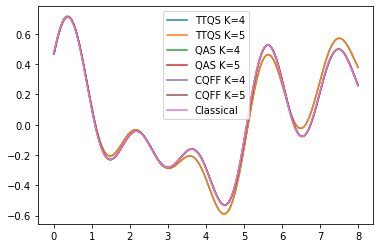

In [9]:
#What Ks we want to plot
whatK = [4,5]

#Plotting results for TTQS
plotp.QS_plotter_forobservable(num_qubits,finalresultsTTQS,times,whatK,'TTQS',observable,initial_state)

#Plotting results for QAS
plotp.QS_plotter_forobservable(num_qubits,finalresultsQAS,times,whatK,'QAS',observable,initial_state)

#Plotting results for CQFF
plotp.QS_plotter_forobservable(num_qubits,finalresultsCQFF,times,whatK,'CQFF',observable,initial_state)

#Plotting classical result
observablematrix = observable.to_matrixform()
classicalresult = cS_instance.get_expectations_observables(observablematrix)
plotp.CS_plotter_forobservable(times,classicalresult)

#Show plot
plotp.show_plot()